# Tutorial 2: Exploratory Data Analysis

In the first tutorial, you learned how to access and work with AWS. Now that our compute infrastructure is set up, we can start with the actual data science work!

This notebooks covers the first and argueably most important aspect of any data science project, the *exploratory data analysis*. Our goal is to get a good understanding of the data we are dealing with.
You will learn how to access the data, learn about the different types of images and how to plot relevant information. 

We assume a basic understanding of Python, but require no prior machine learning experience.

# Setup
The first step in any notebook is loading the relevant libraries and setting global parameters.

In [6]:
sys.path.append('../src')  # Add the source directory to the PYTHONPATH. This allows to import local functions and modules.

In [9]:
from Dataset import OnchoDataset
from detection_util import create_predictions
from gdsc_score import get_leaderboard_score
from gdsc_util import download_directory, download_file, load_sections_df, set_up_logging, PROJECT_DIR
from PredictionEvaluator import PredictionEvaluator

set_up_logging()  # Sets up logging to console and the .log file
data_folder = str(PROJECT_DIR / 'data')

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [10]:
import os
Folderpath = f'{PROJECT_DIR}/data/jpgs'   
 
# get size
for ele in os.scandir(Folderpath):
    s=os.stat(ele).st_size
print(s)

28440728


So far, we only used general Python frameworks. Now, we will also load custom function that were written for this GDSC. Under the folder *../src/gdsc_util.py* you can see the source code. Moving the functionality into a separate file declutters the notebook and makes it easier to understand.

In [6]:
from gdsc_util import download_directory, download_file, load_sections_df, set_up_logging, PROJECT_DIR
set_up_logging()  # Sets up logging to console and the .log file

# Data Overview

Let's start by reviewing the terminology. 
- A nodule is a *worm nest* that was surgically extracted from a patient. Multiple nodules might come from the same patient.
- A nodule slice is, as the name suggest, a very thin piece that was sliced off a nodule and staining for a specific purpose.
- The JPG files you will provided are digitalized microscopic images of nodule slices
- A nodule slice contain multiple worm sections. A worm section is an area where a worm was cut during the slicing of the nodule.

For this challenge, we have access to two types of data. Pictures and tabular data:
- *JPG files* showing slices of nodules
- *gdsc_train.csv*, a CSV that lists the location of worm sections within the JPG files that can be used for training a model. 
- *test_files.csv*, a CSV that lists the names of JPG files that will be used for evaluating your models. 

For each nodule there are usually multiple slices, each with a different staining. E.g. for the nodule 88 you would see four different JPG files: 88_A.jpg, 88_B.jpg, 88_C.jpg and 88_D.jpg. The different stainings help the experts to determine the attributes of the worms, e.g. the vitality, sex, age and whether or not certain bacteria are present.

To take a closer took we first need to make a local copy of the data. For this we utilize our previously imported custom functions. Downloading all the images will take a while so you might want to grab a coffee.

In [5]:
download_directory('jpgs/', local_dir='data')  # Download the JPG images into our data folder
download_file('gdsc_train.csv',local_dir='data')  # Download the list of worm sections
download_file('test_files.csv',local_dir='data')  # Download the files for which we need to create a predictions

2022-07-02 11:28:02,478 - gdsc_util - INFO - Downloading jpgs/ to /home/sagemaker-user/gdsc5-tutorials-public/data


1083it [00:02, 508.28it/s]

2022-07-02 11:28:04,632 - gdsc_util - INFO - Downloaded jpgs/ to /home/sagemaker-user/gdsc5-tutorials-public/data
2022-07-02 11:28:04,643 - gdsc_util - INFO - File gdsc_train.csv already exists. Skipping download
2022-07-02 11:28:04,652 - gdsc_util - INFO - File test_files.csv already exists. Skipping download


'/home/sagemaker-user/gdsc5-tutorials-public/data/test_files.csv'

## Starting the analysis

The file *gdsc_train.csv* contains the bounding boxes of the worm sections within the JPGs. Let's take a closer look and see what we can find.

In [11]:
section_df = load_sections_df(f'{PROJECT_DIR}/data/gdsc_train.csv')
section_df.head(5)

,file_name,study,staining,xmin,xmax,ymin,ymax,height,width
section_id,,,,,,,,,
1_D@2317-5556-2836-6232,1_D.jpg,Study_1,D,2317,2836,5556,6232,8192,7380
1_D@2407-6156-2952-6789,1_D.jpg,Study_1,D,2407,2952,6156,6789,8192,7380
1_D@2483-5836-4279-7287,1_D.jpg,Study_1,D,2483,4279,5836,7287,8192,7380
1_D@2546-1211-4374-2558,1_D.jpg,Study_1,D,2546,4374,1211,2558,8192,7380
1_D@2695-5530-3238-6179,1_D.jpg,Study_1,D,2695,3238,5530,6179,8192,7380


In [15]:
df.columns

Index(['section_id;file_name;study;staining;xmin;xmax;ymin;ymax;height;width'], dtype='object')

In [34]:
df = pd.read_csv('../data/gdsc_train.csv')
tmpDF = pd.DataFrame(columns=['section_id','file_name','study','staining','xmin','xmax','ymin','ymax','height','width'])
tmpDF[['section_id','file_name','study','staining','xmin','xmax','ymin','ymax','height','width']] = df['section_id;file_name;study;staining;xmin;xmax;ymin;ymax;height;width'].str.split(';', expand=True)


In [43]:
tmpDF.head(5)

,section_id,file_name,study,staining,xmin,xmax,ymin,ymax,height,width
0,1_D@2317-5556-2836-6232,1_D.jpg,Study_1,D,2317,2836,5556,6232,8192,7380
1,1_D@2407-6156-2952-6789,1_D.jpg,Study_1,D,2407,2952,6156,6789,8192,7380
2,1_D@2483-5836-4279-7287,1_D.jpg,Study_1,D,2483,4279,5836,7287,8192,7380
3,1_D@2546-1211-4374-2558,1_D.jpg,Study_1,D,2546,4374,1211,2558,8192,7380
4,1_D@2695-5530-3238-6179,1_D.jpg,Study_1,D,2695,3238,5530,6179,8192,7380


In [47]:
tmpDF.loc[tmpDF['file_name'] == '300_B.jpg']

,section_id,file_name,study,staining,xmin,xmax,ymin,ymax,height,width
32052,300_B@0618-6138-0953-6328,300_B.jpg,Study_3,B,618,953,6138,6328,8192,5978
32053,300_B@1842-6213-2248-6408,300_B.jpg,Study_3,B,1842,2248,6213,6408,8192,5978
32054,300_B@2099-6093-2320-6235,300_B.jpg,Study_3,B,2099,2320,6093,6235,8192,5978
32055,300_B@2264-6100-2562-6318,300_B.jpg,Study_3,B,2264,2562,6100,6318,8192,5978
32056,300_B@2289-3066-2485-3221,300_B.jpg,Study_3,B,2289,2485,3066,3221,8192,5978
...,...,...,...,...,...,...,...,...,...,...
32135,300_B@5085-2881-5304-3086,300_B.jpg,Study_3,B,5085,5304,2881,3086,8192,5978
32136,300_B@5194-2672-5421-2904,300_B.jpg,Study_3,B,5194,5421,2672,2904,8192,5978
32137,300_B@5231-3240-5486-3464,300_B.jpg,Study_3,B,5231,5486,3240,3464,8192,5978
32138,300_B@5415-2895-5715-3131,300_B.jpg,Study_3,B,5415,5715,2895,3131,8192,5978


The DataFrame is relatively simple and consists of nine columns with the following meaning:

| **Column Name** | **Description**                              |
|--------------|-------------------------------------------|
| section_id   | A unique identifier for each worm section.                 |
| file_name     | The JPG file in which this worm section can be seen. |
| study        | The name of the clinical study from which the nodule was extracted.                                          |
| staining     | How the image was stained. |
| xmin         | The leftmost value of the worm section on the x-axis  |
| xmax         | The rightmost value of the worm section on the x-axis |
| ymin         | The smallest value of the worm section on the y-axis |
| ymax         | The largest value value of the worm section on the y-axis |
| height       | The height of the JPG in pixels                      |
| width        | The width of the JPG in pixels                       |



The [pandas library](https://pandas.pydata.org/docs/) offers an amazing amount of functionality out of the box. E.g.

In [7]:
section_df.describe(include='all')

2022-07-02 11:28:23,321 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


,file_name,study,staining,xmin,xmax,ymin,ymax,height,width
count,65687,65687,65687,65687.000000,65687.000000,65687.000000,65687.000000,65687.000000,65687.000000
unique,994,4,5,NaN,NaN,NaN,NaN,NaN,NaN
top,253_A.jpg,Study_2,A,NaN,NaN,NaN,NaN,NaN,NaN
freq,381,31698,28888,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,3052.965016,3398.934005,3564.859516,3938.694156,7637.242514,6630.876932
std,NaN,NaN,NaN,1465.420779,1487.173251,1662.618643,1680.965494,1175.230607,1383.557949
min,NaN,NaN,NaN,19.000000,221.000000,12.000000,143.000000,3521.000000,2904.000000
25%,NaN,NaN,NaN,1917.000000,2249.000000,2234.000000,2590.000000,8017.000000,5574.000000
50%,NaN,NaN,NaN,2887.000000,3245.000000,3431.000000,3824.000000,8192.000000,6668.000000
75%,NaN,NaN,NaN,4025.000000,4389.000000,4829.500000,5234.000000,8192.000000,8192.000000


that allows us to get a quick overview of the data. Together with

In [8]:
len(section_df)

65687

we can conclude that there are no missing values for any column since the count for each columns is also 65687.

**Learnings:**
- gdsc_train.csv contains data about the worm sections in the images in the form of bounding boxes.
- There are no missing values in the csv

**Exercise:**
The above analysis only covered the very basics. There are many other things you can investigate. E.g.
- Are there duplicate entries?
- What is the distribution of worm sections per nodule slice?
- What is distribution of the size of the worm sections? (Male worms tend to be smaller than females)
- Can worm sections overlap? If yes, how often does this appear?

## Visualizing worm sections
Together, the values of *xmin*, *xmax*, *ymin* and *ymax* define the *bounding box* of a worm section. Let's take a look at a single worm section.

In [9]:
example_section = section_df.loc['1_D@2317-5556-2836-6232']
example_section

file_name    1_D.jpg
study        Study_1
staining           D
xmin            2317
xmax            2836
ymin            5556
ymax            6232
height          8192
width           7380
Name: 1_D@2317-5556-2836-6232, dtype: object

Next, we will plot the worm section in the JPG.

In [10]:
img = Image.open(f'{PROJECT_DIR}/data/jpgs/1_D.jpg')  # Load the image

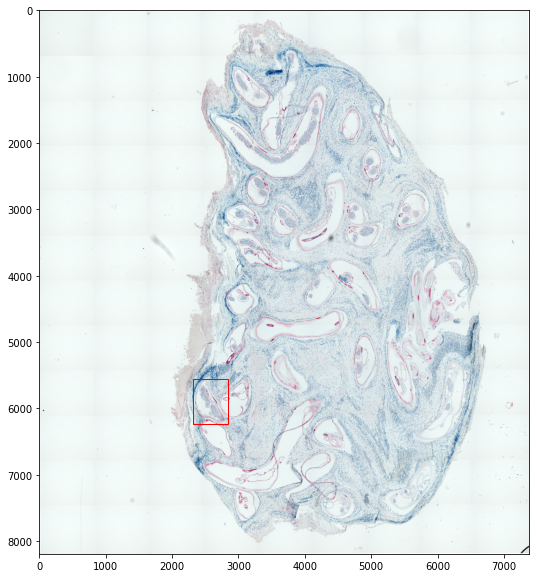

In [11]:
plt.figure(figsize=(10,10))  # Set the size of the image
plt.imshow(img)  # Show the image

ax = plt.gca()  # Get the axis

# Create a Rectangle patch for the worm section
width = example_section.xmax - example_section.xmin
height = example_section.ymax - example_section.ymin
rect = Rectangle((example_section.xmin,example_section.ymin),width,height,linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(rect)  # Add the rectangle to the axis   

The red rectangle is drawn around on of the obvious places where a worm was cut. We can also plot all the worm sections we have for an image via

In [11]:
image_worm_sections = section_df[section_df.file_name == '1_D.jpg']
len(image_worm_sections)

40

In [12]:
image_worm_sections

,file_name,study,staining,xmin,xmax,ymin,ymax,height,width
section_id,,,,,,,,,
1_D@2317-5556-2836-6232,1_D.jpg,Study_1,D,2317,2836,5556,6232,8192,7380
1_D@2407-6156-2952-6789,1_D.jpg,Study_1,D,2407,2952,6156,6789,8192,7380
1_D@2483-5836-4279-7287,1_D.jpg,Study_1,D,2483,4279,5836,7287,8192,7380
1_D@2546-1211-4374-2558,1_D.jpg,Study_1,D,2546,4374,1211,2558,8192,7380
1_D@2695-5530-3238-6179,1_D.jpg,Study_1,D,2695,3238,5530,6179,8192,7380
1_D@2717-4697-3175-5374,1_D.jpg,Study_1,D,2717,3175,4697,5374,8192,7380
1_D@2793-2905-3375-3356,1_D.jpg,Study_1,D,2793,3375,2905,3356,8192,7380
1_D@2801-4111-3264-4619,1_D.jpg,Study_1,D,2801,3264,4111,4619,8192,7380
1_D@2809-3275-3736-3944,1_D.jpg,Study_1,D,2809,3736,3275,3944,8192,7380


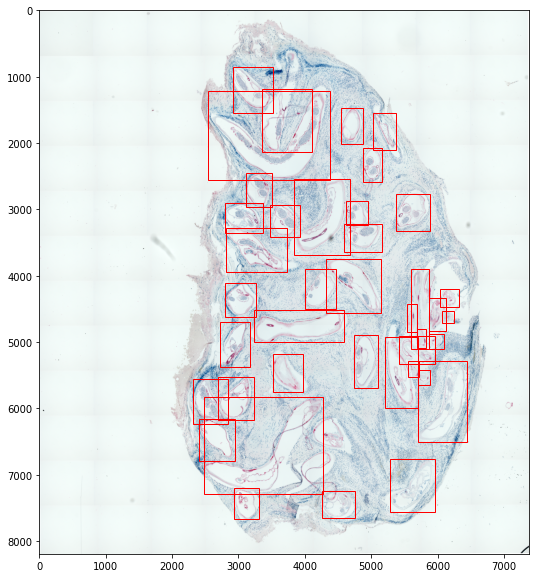

In [13]:
plt.figure(figsize=(10,10))  # Set the size of the image
plt.imshow(img)  # Show the image
ax = plt.gca()  # Get the axis

# Draw the boxes for all worm sections
for row in image_worm_sections.itertuples():
    # Create a Rectangle patch
    width = row.xmax - row.xmin
    height = row.ymax - row.ymin
    rect = Rectangle((row.xmin,row.ymin),width,height,linewidth=1,edgecolor='r',facecolor='none')  # define rectangle
    ax.add_patch(rect)  # Add the rectangle to the axis    

This image nicely illustrates some of the challenges of our task.

**Learnings:**
- The size of the worm sections varies a lot. 
- Some of the bigger worm sections may fully encompass smaller worm sections
- The labels are not perfect. If you look closely at the middle of the lower half it seems that there is one worm sections that wasn't marked.


**Exercise:**
- Plot the worm sections for three different images. Pick different stainings for each plot.

## Visualizing different stainings

Previously, we mentioned that there are multiple images for each nodule. Each images focusses on a different aspect. As we will see the different stainings produce very different images. If you take a look at the S3 bucket, you'll see that there are five different images for the *100* nodule. Let's plot them.

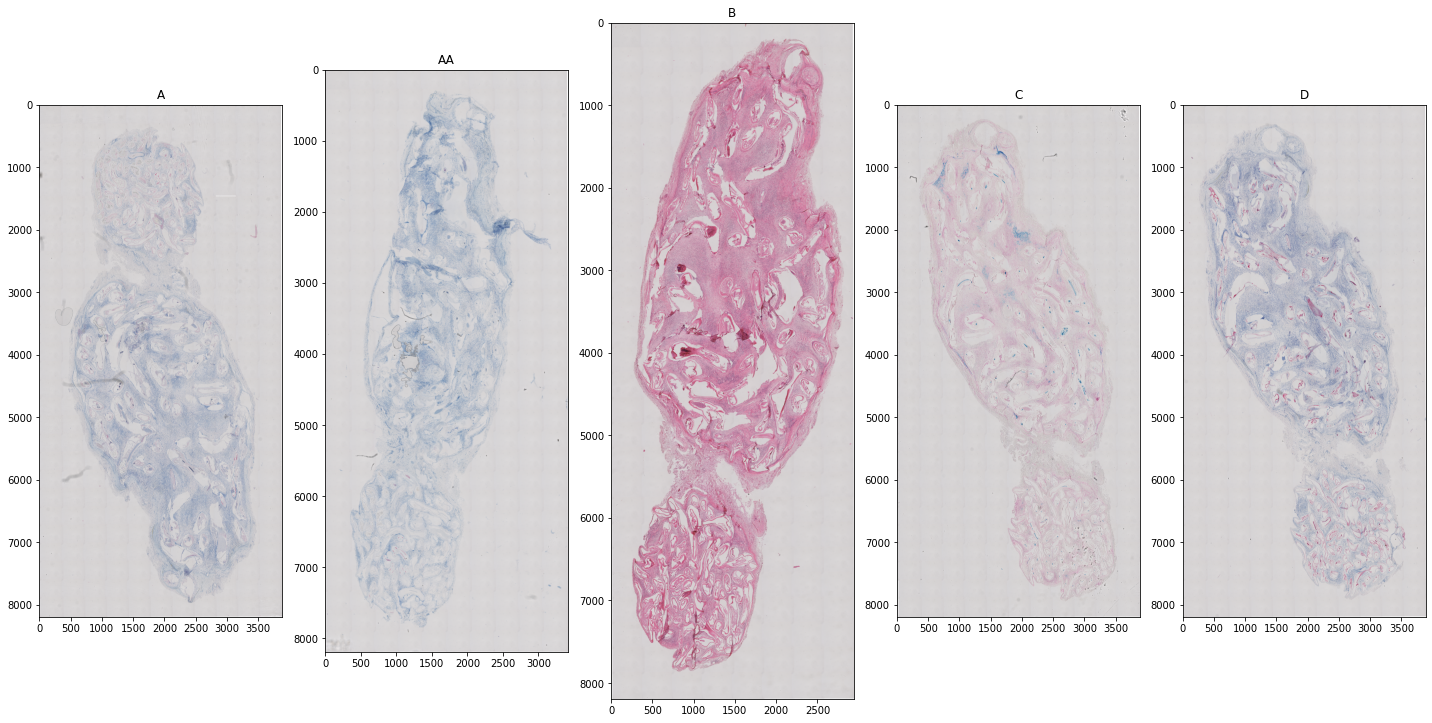

In [12]:
# Load the images for nodule 100
img_a = Image.open(f'{PROJECT_DIR}/data/jpgs/100_A.jpg')
img_aa = Image.open(f'{PROJECT_DIR}/data/jpgs/100_AA.jpg')
img_b = Image.open(f'{PROJECT_DIR}/data/jpgs/100_B.jpg')
img_c = Image.open(f'{PROJECT_DIR}/data/jpgs/100_C.jpg')
img_d = Image.open(f'{PROJECT_DIR}/data/jpgs/100_D.jpg')

# Plot the images on a 1x5 grid
plt.figure(figsize=(20,30), tight_layout=True)
plt.subplot(1, 5, 1)
plt.imshow(img_a)
plt.title('A')

plt.subplot(1, 5, 2)
plt.imshow(img_aa)
plt.title('AA')

plt.subplot(1, 5, 3)
plt.imshow(img_b)
plt.title('B')

plt.subplot(1, 5, 4)
plt.imshow(img_c)
plt.title('C')

plt.subplot(1, 5, 5)
plt.imshow(img_d)
plt.title('D')

plt.show()

At a first glance these images do not seem to show the same nodule. What's going on? 
To understand the differences we must consider how the images are taken. Remember that each images shows a different slice of the nodule and the slices are put on a small platter and viewed under a microscope. 
These platters might be rotated and/or flipped. After all there is no indicator that defined where the top or bottom of a nodule is! If we apply this to our images can see that after rotating/flipping the images they indeed show the same nodule.

A second thing to take away here is that the different stainings look very different. Even from this high-level view you can easily see that e.g. the colors in an B picture are very different from the colors in an D image.
So whatever model we will build needs to be able to account for this.

**Note:** Keep in mind that we only looked at a single nodule. Our findings might not be representative. Before you make any judgement you should view a relevant subset of images.

**Learnings:**
- Stainings look very different. Any model must be able to handle big differences in colors and intensity.
- We may have to rotate/flip images from a single nodule if we want to align them.

**Exercise:**
- Plot all stainings for multiple other nodules.
- Take a closer look at the individual staining by looking at the source JPGs directly. Write down all the differences you can make out.

## Analysing the training labels

So far, we looked at individual images at not the overall picture. There is some more information we can get from *gdsc_train.csv*. 

We already saw that different stainings produce very different pictures. Which raises the question, how many images to we have for each staining?

<AxesSubplot:>

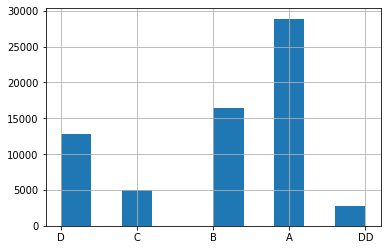

In [15]:
section_df['staining'].hist()

As the graphs shows, the large majority of sections are from A images. This imbalance could become on issue once we're training our first model.

As an alternative to counting the number of worm sections, we can also consider the number of nodule images.

In [16]:
nodules = section_df.groupby(['file_name','staining','study']).size().reset_index()  # Group the data by nodule image
nodules.head(5)

,file_name,staining,study,0
0,102_A.jpg,A,Study_2,20
1,102_D.jpg,D,Study_2,18
2,103_A.jpg,A,Study_2,79
3,103_A_2nd_stain.jpg,A,Study_2,86
4,103_B.jpg,B,Study_2,73


<AxesSubplot:>

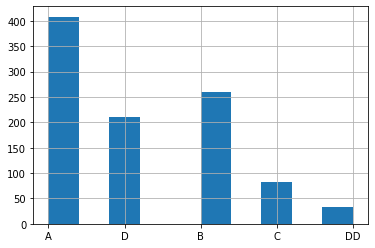

In [17]:
nodules['staining'].hist()

While the numbers change, the overall message stays the same. A images are the most frequent. C and DD the rarest.

Another dimension to consider is the distribution among different studies. As studies were done at different stages of mass drug administration we might expect some differences in the images.

In [18]:
section_df.study.unique()

<StringArray>
['Study_1', 'Study_2', 'Study_3', 'Study_4']
Length: 4, dtype: string

Overall, we have data from four different studies, Study_1, Study_2, Study_3 and Study_4. We also know that the images on which our models will be evaluated on come from yet another study. 

array([[<AxesSubplot:title={'center':'Study_1'}>,
        <AxesSubplot:title={'center':'Study_2'}>],
       [<AxesSubplot:title={'center':'Study_3'}>,
        <AxesSubplot:title={'center':'Study_4'}>]], dtype=object)

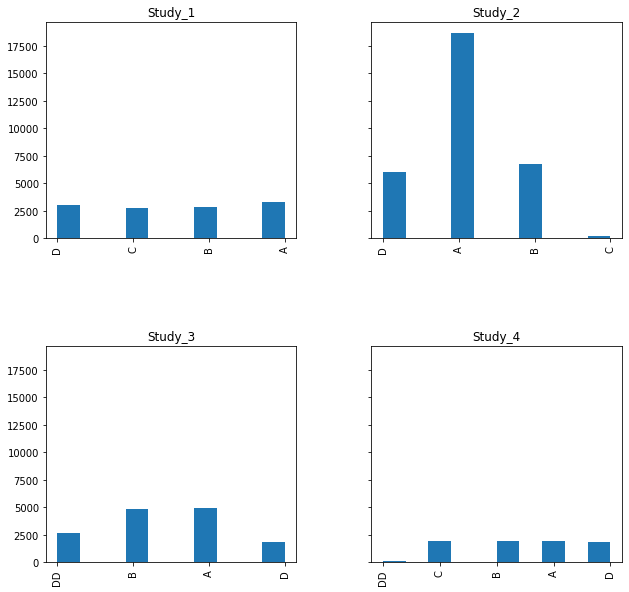

In [19]:
section_df['staining'].hist(by=section_df['study'], figsize=(10,10), sharey=True)

Counting sections, the majority of data comes from the Study_2 study. For Study_4 we have the least amount of data. 
Looking at the number of nodule images gives similar results. 

array([[<AxesSubplot:title={'center':'Study_1'}>,
        <AxesSubplot:title={'center':'Study_2'}>],
       [<AxesSubplot:title={'center':'Study_3'}>,
        <AxesSubplot:title={'center':'Study_4'}>]], dtype=object)

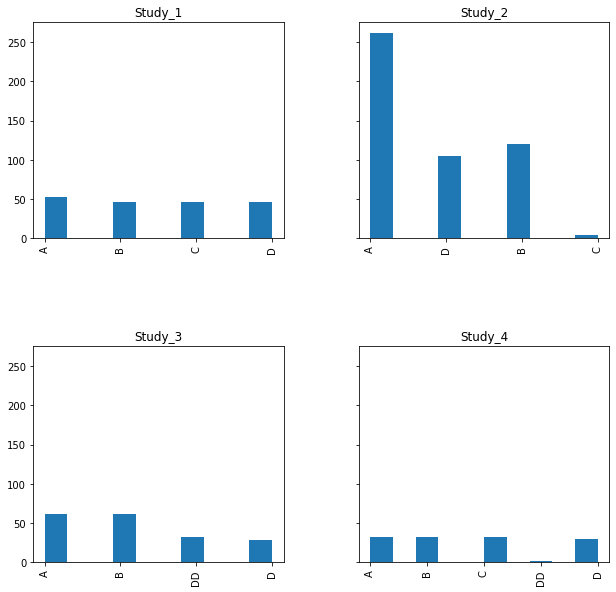

In [20]:
nodules['staining'].hist(by=nodules['study'], figsize=(10,10), sharey=True)

Note the arguments of the .hist() call. *figsize* determins the size of the plot, *sharey* ensure that all plots use the same y labels. See [the documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) for more options.

**Learnings:**
- There is an imbalance in the number of nodules per staining with most images showing an A staining.
- There is also an imbalance in the number of nodules per study with the majority of images coming from the Study_2 study.

**Exercise:**
- Create a plot that shows the relative number of sections/images instead of the absolute numbers.
- Review multiple images from the individual studies. Can you determine any significant differences between the studies? If yes, could this have an impact on the AI training?
- Analyse the number of worm sections per image. What is the min, max and average number of worm sections? Are there any differences between studies?
- The build in plotting functionality for dataframes is handy but has its drawbacks. E.g. the columns don't properly align with the descriptions on the x-axis and for the study plots every subplot has its own x-axis. Create better plots with the [seaborn](https://seaborn.pydata.org/examples/index.html) framework.

# Summary
In this tutorial we had a first investigation of the available data. We learned how to download the data, about the different types of stainings and the imbalances of our dataset. A good understanding of the data you are working with is an essential part of any data science project and is a requirement for being able to build a good solution. This notebook showed you the first steps. 

In the next tutorial we will build a first simple object detection model and submit our first results.